# Dismantling the bulk: examining neuronal heterogeneity using single-cell techniques

Sara Linker, Apua Paquola, Roger Lasken, and Keegan Korthauer

Festival of Genomics

9/19/2016



# Hour II: Quality control and normalization

The readout from a RNA-Seq experiment is a mixture of a **biological** and **technical** sources.

The goal of quality control is to capture **metrics** and evaluate the **technical quality** of each sample, and help decide which samples to keep and which to exclude from the analysis.

The data from samples with enough quality still carry features that have to do with the technical processing of samples and are unrelated to the biology. 

The goal of normalization is to apply a **transformation** to the data to factor out the technical component, making the samples **comparable**.

We will start with quality control, evaluating a set of metrics.


### Load libraries and set up jupyter display option

We set this option for Jupyter to display tables and plots correctly.

We load R libraries we will use: ggplot2 for general plotting, and scone to evaluate normalization strategies.

In [198]:
options(jupyter.rich_display = TRUE)

In [199]:
library(scone)
library(ggplot2)

### Load data

**gene_counts** is a data frame containing unnormalized read counts per gene

**ercc_counts** is a data frame containing raw read counts per ERCC spike-in 

**cells** is a data frame containing metadata for each cell

In [4]:
gene_counts <- read.csv("../../_m/genes_counts.csv", stringsAsFactors = FALSE, header=TRUE, row.names = 1)
ercc <- read.csv("../../_m/ercc_counts.csv", stringsAsFactors = FALSE, header = TRUE, row.names=1)
cells <- read.csv("../../_m/cell_metadata.csv", stringsAsFactors = FALSE, header = TRUE)

whichTomato <- grep("tdTomato", rownames(ercc))
ercc <- ercc[-whichTomato,]

### Examine sizes of data frames

gene_counts: 24057 genes x 1679 cells

ercc: 92 spike-ins x 1679 cells

cells: 1679 cells x 16 metadata fields




In [200]:
dim(gene_counts)

[1] 24057  1679

In [201]:
dim(ercc)

[1]   92 1679

In [202]:
dim(cells)

[1] 1679   16

### Examine metadata

Some of the metadata fields contain information about the biological sample, some about sequencing metrics.

In [8]:
head(cells)

long_name,cre,collection_date,sequencing_type,total_reads,all_mapped_percent,mRNA_percent,genome_percent,ercc_percent,tdt_permillion,major_class,sub_class,major_dissection,layer_dissectoin,color_code,short_name
A01101401,Calb2,11/18/2013,hiseq,23770190,93.50,54.43,30.08,4.36,306.1,Inhibitory,Vip,V1,All,11,A200_V
A01101402,Calb2,11/18/2013,hiseq,9694719,92.86,45.69,35.45,7.84,341.2,Inhibitory,Vip,V1,All,11,A201_V
A01101403,Calb2,11/18/2013,hiseq,5864322,90.55,48.30,34.01,4.12,106.2,Excitatory,L4,V1,All,11,A202_V
A01101404,Calb2,11/18/2013,hiseq,22102121,93.25,51.41,33.81,4.24,371.1,Inhibitory,Vip,V1,All,11,A203_V
A01101405,Calb2,11/18/2013,hiseq,24057147,93.14,51.06,32.11,4.98,264.2,Inhibitory,Vip,V1,All,11,A204_V
A01101406,Calb2,11/18/2013,hiseq,24171169,92.18,49.31,35.85,3.14,205.8,Excitatory,L2/3,V1,All,11,A205_V


### Select fields from metadata that are useful for QC

Select fields related to sequencing and mapping

In [161]:
qc <- cells[,c('total_reads', 'all_mapped_percent', 'mRNA_percent', 'ercc_percent', 'tdt_permillion')]
rownames(qc) <- cells$long_name

### Add two more fields to the qc dataframe: number of genes detected and number of ERCC spike-ins detected

In [162]:
all.equal(cells$long_name, colnames(gene_counts)) && all.equal(cells$long_name, colnames(ercc))

[1] TRUE

In [163]:
qc$ercc_detected = colSums(ercc > 0)

In [164]:
qc$genes_detected = colSums(gene_counts > 0)

### Here's how the QC dataframe looks like

In [255]:
head(qc)

,total_reads,all_mapped_percent,mRNA_percent,ercc_percent,tdt_permillion,ercc_detected,genes_detected
A01101401,23770190,93.50,54.43,4.36,306.1,34,8308
A01101402,9694719,92.86,45.69,7.84,341.2,29,6001
A01101403,5864322,90.55,48.30,4.12,106.2,33,6318
A01101404,22102121,93.25,51.41,4.24,371.1,41,8354
A01101405,24057147,93.14,51.06,4.98,264.2,34,8128
A01101406,24171169,92.18,49.31,3.14,205.8,39,9111


### Plot the distribution of these metrics

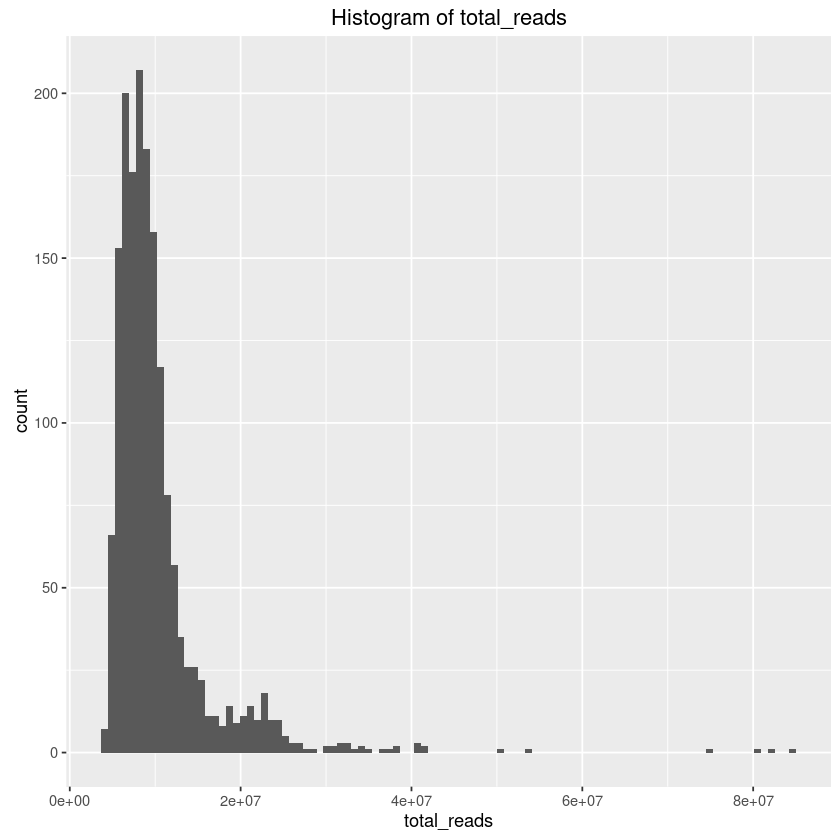

In [166]:
ggplot(cells, aes(x=total_reads)) + geom_histogram(bins=100) + ggtitle('Histogram of total_reads')

In [247]:
summary(qc$total_reads)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
 3782000  6901000  8667000 10240000 10930000 84330000 

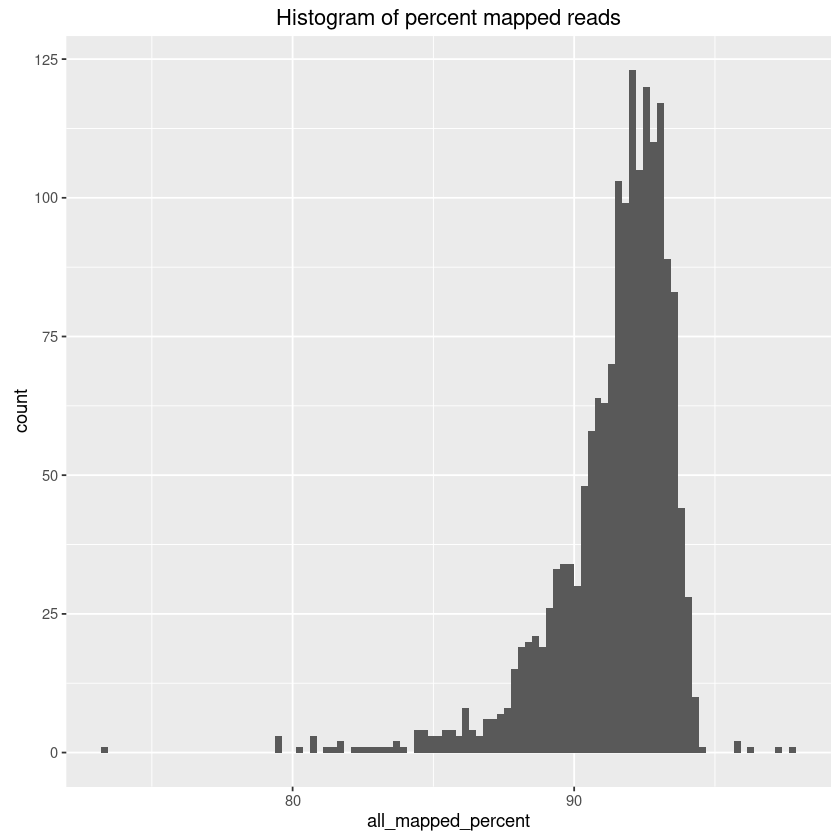

In [168]:
ggplot(qc, aes(x=all_mapped_percent)) + geom_histogram(bins=100)  + ggtitle('Histogram of percent mapped reads')

In [248]:
summary(qc$all_mapped_percent)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  73.36   90.66   91.95   91.43   92.85   97.80 

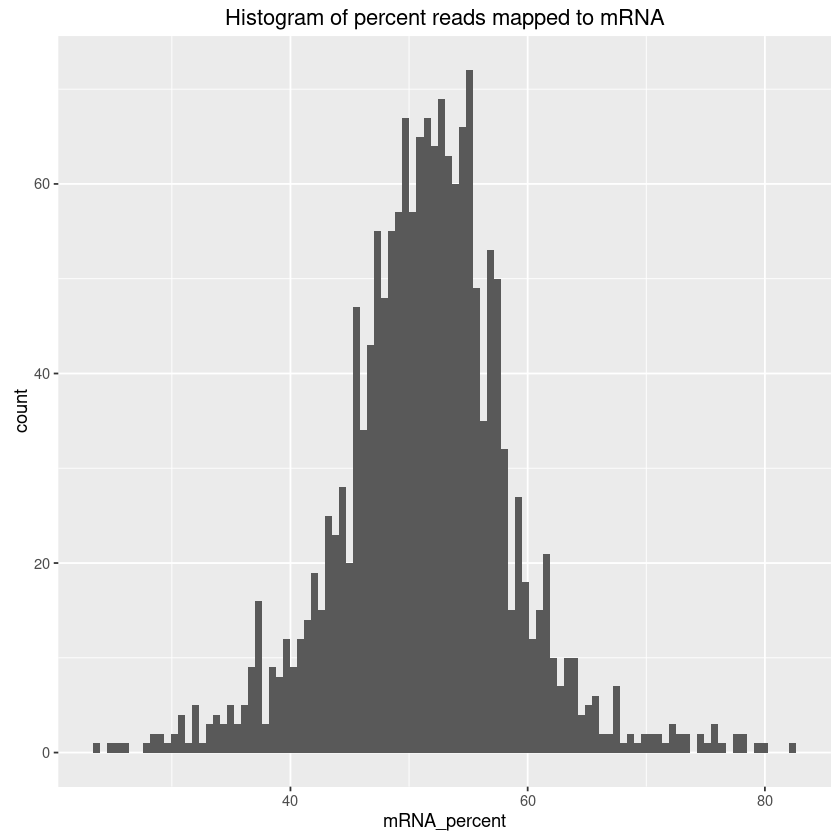

In [169]:
ggplot(qc, aes(x=mRNA_percent)) + geom_histogram(bins=100) + ggtitle('Histogram of percent reads mapped to mRNA')

In [249]:
summary(qc$mRNA_percent)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  23.94   47.36   51.59   51.39   55.39   82.56 

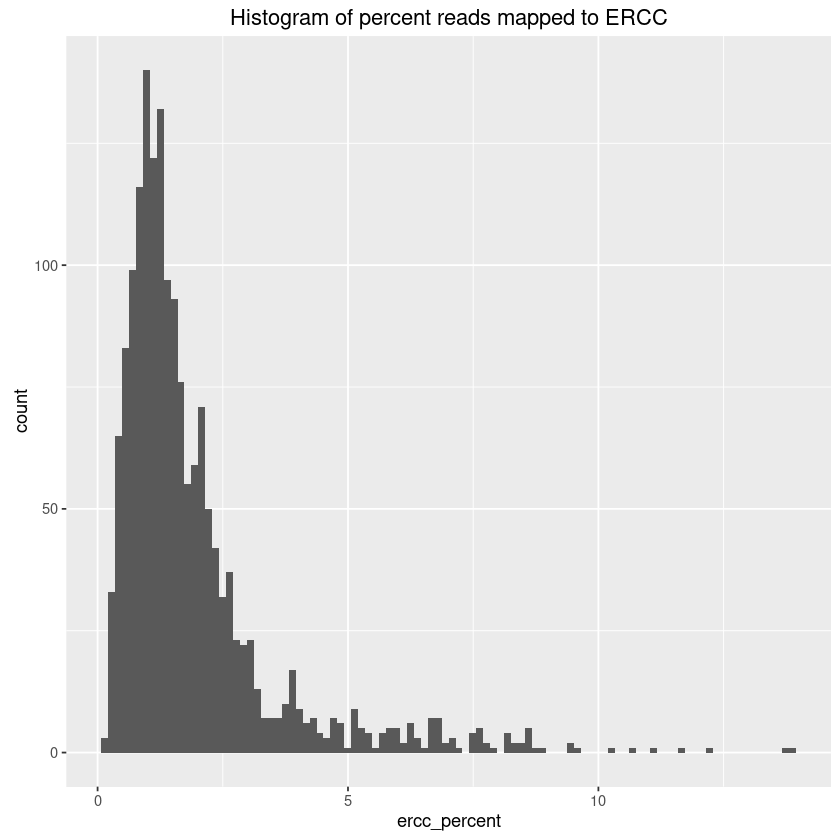

In [170]:
ggplot(qc, aes(x=ercc_percent)) + geom_histogram(bins=100) + ggtitle('Histogram of percent reads mapped to ERCC')

In [250]:
summary(qc$ercc_percent)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.160   0.920   1.370   1.887   2.190  13.900 

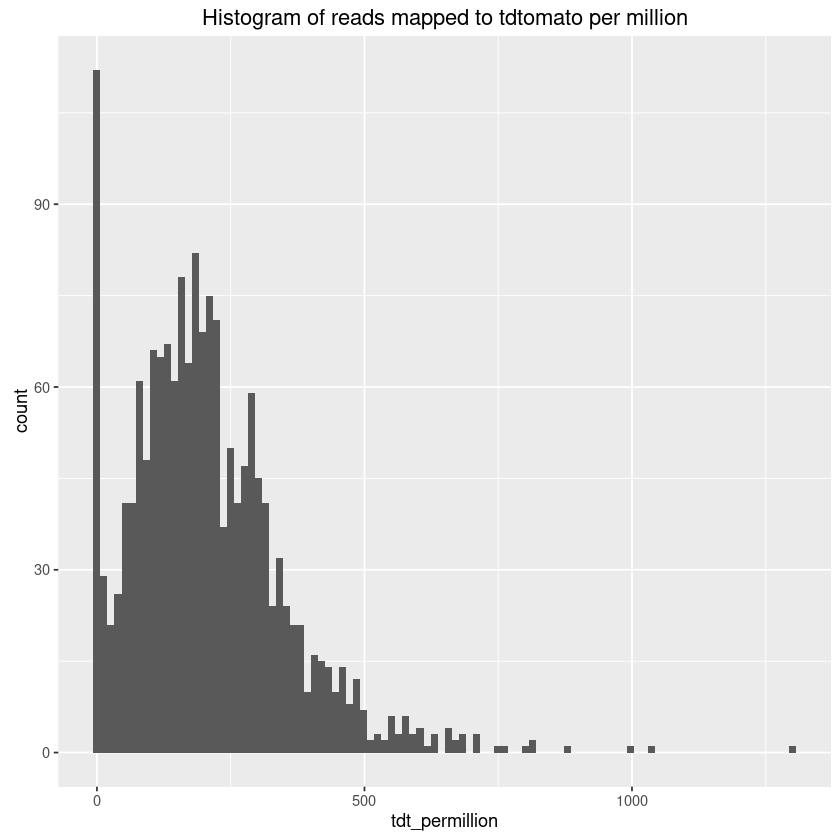

In [251]:
ggplot(qc, aes(x=tdt_permillion)) + geom_histogram(bins=100) + ggtitle('Histogram of reads mapped to tdtomato per million')

In [252]:
summary(qc$tdt_permillion)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    0.0   106.7   185.9   205.7   284.2  1300.0 

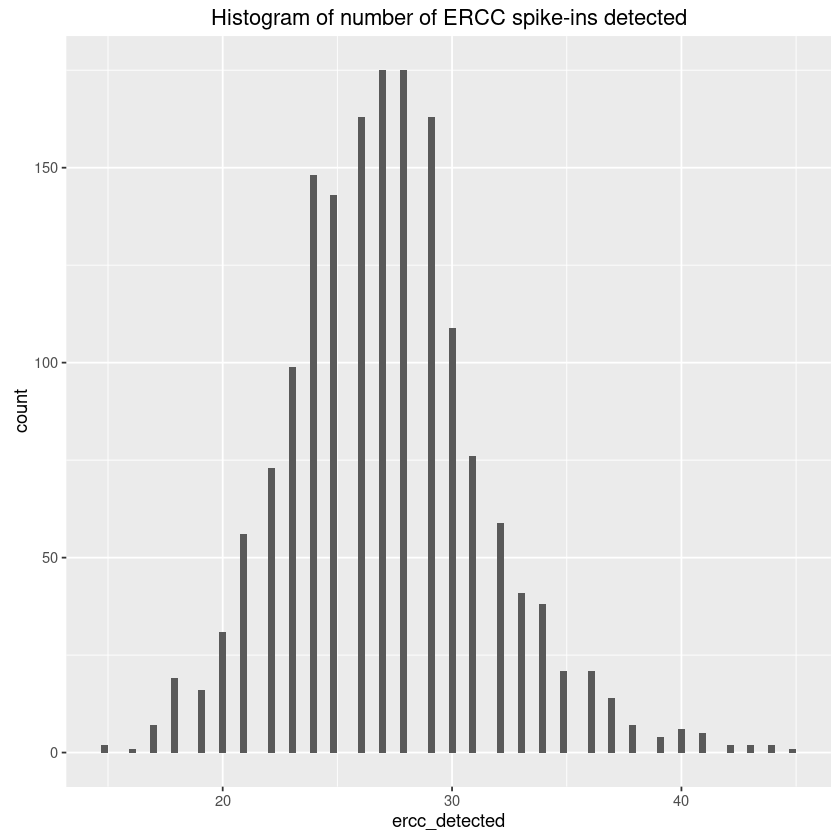

In [172]:
ggplot(qc, aes(x=ercc_detected)) + geom_histogram(bins=100) + ggtitle('Histogram of number of ERCC spike-ins detected')

In [253]:
summary(qc$ercc_detected)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  15.00   24.00   27.00   27.13   29.00   45.00 

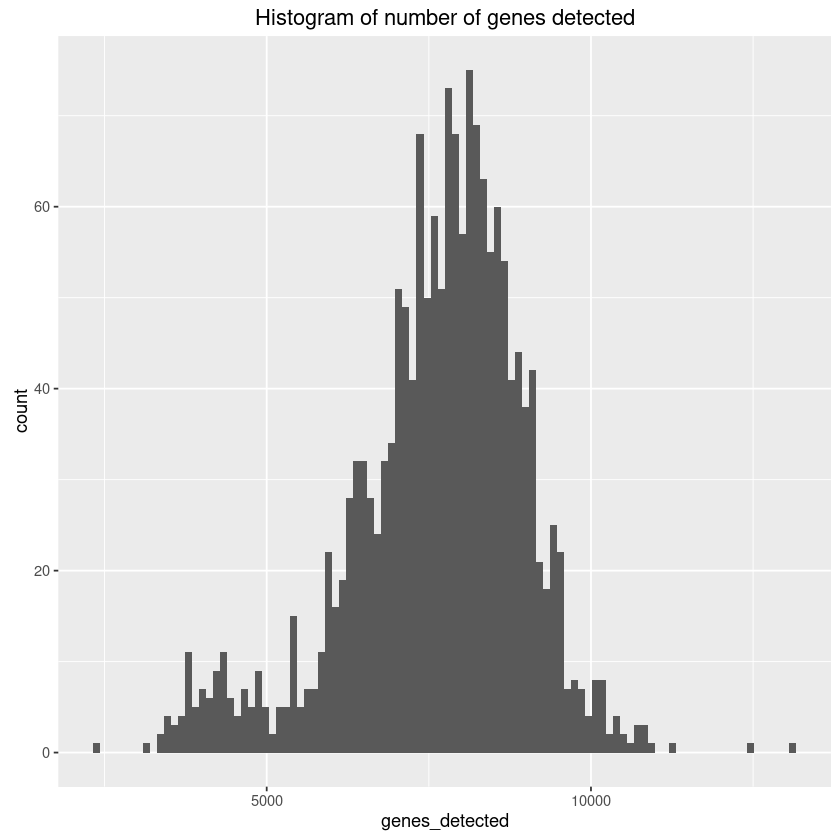

In [173]:
ggplot(qc, aes(x=genes_detected)) + geom_histogram(bins=100) + ggtitle('Histogram of number of genes detected')

In [254]:
summary(qc$genes_detected)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   2402    6966    7811    7626    8508   13120 

### Other metrics commonly used for QC

1. GC content
2. k-mer content
3. %reads mapping to mitochondria: high mitochondria/genome ratio suggests apoptotic cell
4. %reads mapping to introns or intergenic regions



### Identifying outlying samples by PCA of QC metrics

We can use PCA to visualize each sample with respect to QC metrics and pick outliers.

In [208]:
qc_pc_obj = prcomp(qc, center = TRUE, scale=TRUE)

In [209]:
#ggplot(as.data.frame(qc_pc_obj$x), aes(x=PC1, y=PC2)) + geom_point()

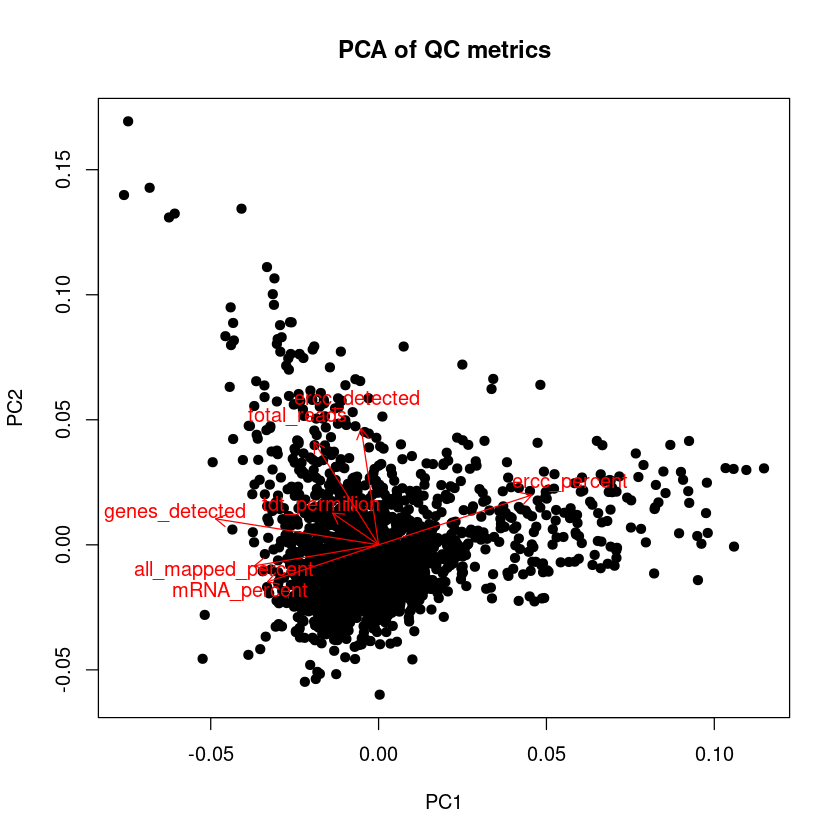

In [210]:
qc_bp_obj = biplot_colored(qc_pc_obj, y=1, expand = .8, choices=1:2)
title('PCA of QC metrics')

## We don't find low quality outliers
The samples on the top left have very high number of reads (and that is good), and this is what causes PC2 to be high.

The authors of the paper had already excluded low-quality samples from this dataset.

# Normalization


The purpose of normalization is to make datasets from different cells comparable. 

Normalization strategies range from simple scaling (e.g. dividing raw counts by the total number of reads), to a more complex schemes that adjust for batch effects and biological effects.

Too much adjustment can cut away biological signal and/or introduce artifacts.

There is no normalization strategy that is optimal for all datasets. 

Many normalization strategies should be considered.


Some common normalization strategies for RNA-Seq

name | long name | notes 
---:|---:
RPM | reads per million | (counts / total reads ) * 1 million
RPKM or FPKM| fragments per kilobase per million | takes gene aclength into account
TPM | transcripts per million | takes gene length into account
FQ | full quantile | match quantiles across samples
UQ | upper quartile | upper quartile of read counts define scaling factor
TMM | trimmed mean of M values (edgeR) | weighted log-fold-change values of a reference sample, removing genes with extreme values
DESeq | DESeq | scales samples to a reference sample based on the geometric mean of read counts across all samples






## Testing multiple normalization strategies with SCONE

SCONE (Single-Cell Overview of Normalized Expression) supports a rational, data-driven framework for assessing the efficacy of various normalization workflows, encouraging users to explore trade-offs inherent to their data set prior to finalizing a data normalization strategy. It provides an interface for running multiple normalization workflows in parallel. It also offers tools for ranking workflows and visualizing trade-offs. It imports some common normalization modules used in traditional bulk sequencing, and provide support for integrating user-specified normalization modules.

R package on github:

https://github.com/YosefLab/scone


More information and usage examples:

https://niryosef.wordpress.com/tools/scone/

https://www.bioconductor.org/help/course-materials/2016/BioC2016/ConcurrentWorkshops1/Risso/scone.html


## How it works

A normalization strategy is composed of a series of steps, each step being optional and having its specific parameters.
SCONE tries all combinations of steps and parameters, evaluating many normalization strategies through metrics.

1. imputation - replace zeroes by average values - options: imputation or no imputation
2. scaling - scaling normalization strategy - options: none, UQ, FQ, DeSeq, . 
3. RUVg - normalization with housekeeping genes or spike-ing - options: none, k=1, k=2, k=3 (k = number of parameters)
4. batch adjustment - whether to adjust for batch effects - options: yes or no
5. bio adjustment - whether to adjust for biological factors - options: yes or no


RUV: Remove Unwanted Variation from RNA-Seq Data
bioconductor package RUVSeq

Risso D, Ngai J, Speed T and Dudoit S (2014). “Normalization of RNA-seq data using factor analysis of control genes or samples.” Nature Biotechnology, 32(9), pp. 896–902. In press, http://www.nature.com/nbt/journal/v32/n9/full/nbt.2931.html. 

### Make sure column names of genes and ercc matrices are compatible

In [5]:
all.equal(colnames(gene_counts), colnames(ercc))

[1] TRUE

### Create a combined matrix of gene and ercc counts

In [6]:
gene_and_ercc_counts <- rbind(gene_counts, ercc)
dim(gene_and_ercc_counts)

[1] 24149  1679

### Filter out genes and ERCCs with very low counts over all samples

In [7]:
f_gene_and_ercc_counts <- gene_and_ercc_counts[rowSums(gene_and_ercc_counts > 0) >= 50, ]
f_ercc <- rownames(ercc)[rownames(ercc) %in% rownames(f_gene_and_ercc_counts)]

### Set up biological and batch factors

For **bio**, we use the dissection layer obtained from metadata.

For **batch**, we use the month of sample collection, obtained from metadata.

In [214]:
colection_month = gsub("([0-9]+)/[0-9]+/([0-9]+)", "\\1/\\2", cells$collection_date)
batch <- factor(colection_month)
bio <- factor(cells$layer_dissectoin)

In [215]:
table(batch, bio)

         bio
batch     All  L1 L2/3  L4  L5  L6 L6a L6b lower upper
  10/2014 114   0    0   0   0   0   0  28     0     0
  11/2013  24   0    0  45   0   0   3   0    16    16
  11/2014 154  19   31   0   0   0  35  13     0     0
  1/2014   31   0    0  61  23   0  30   0     0     0
  12/2013  61   0    0   0   0   0  24   0     0     0
  12/2014   8   0    0   0   0  13   0   0    34    72
  2/2014    8   0    0  80   0   0   0   0     6     0
  2/2015    0   0    0   0   0   0  20   0     0     0
  3/2014   31   0    0  23  16   0   0   0     0     0
  4/2014    0   0    0   0 101   0   0   0     0     0
  5/2014   44   0    0   0   0   0   0   0     0     0
  6/2014   16   0   24   0   0   0   0   0    44    45
  7/2013    0   0    0   0   3   0   0   0     0     0
  7/2014   48  19    0   7   0   0   0   0    44    46
  8/2013    0   0    8   8   0   0   0   0     0     0
  8/2014  157   0    0   0   0  20   0   0     0     0
  9/2014    6   0    0   0   0   0   0   0     0    

### Set up a SCONE run

We use (no_normalization, DESeq, TMM, UQ, FQ) as candidate scaling strategies
We use the ERCC spike ins for RUVg

In [221]:
params <- scone(expr = as.matrix(f_gene_and_ercc_counts),
                scaling = c(none = identity, deseq = DESEQ_FN, tmm = TMM_FN, uqp = UQ_FN_POS, fq = FQT_FN),
                ruv_negcon = f_ercc, k_ruv = 3,
                k_qc = 0,
                bio = bio, adjust_bio = "yes",
                batch = batch, adjust_batch = "yes",
                run = FALSE)

### Eliminate combinations of steps that are not meaningful
We don't want to adjust for biological factor unless we also adjust for batch factors.

In [218]:
is_screened = (params$adjust_biology == "bio") & (params$adjust_batch != "batch")
params = params[!is_screened,]

### Here are the strategies to be tested

In [219]:
params

,imputation_method,scaling_method,uv_factors,adjust_biology,adjust_batch
"none,none,no_uv,no_bio,no_batch",none,none,no_uv,no_bio,no_batch
"none,deseq,no_uv,no_bio,no_batch",none,deseq,no_uv,no_bio,no_batch
"none,tmm,no_uv,no_bio,no_batch",none,tmm,no_uv,no_bio,no_batch
"none,uqp,no_uv,no_bio,no_batch",none,uqp,no_uv,no_bio,no_batch
"none,fq,no_uv,no_bio,no_batch",none,fq,no_uv,no_bio,no_batch
"none,none,ruv_k=1,no_bio,no_batch",none,none,ruv_k=1,no_bio,no_batch
"none,deseq,ruv_k=1,no_bio,no_batch",none,deseq,ruv_k=1,no_bio,no_batch
"none,tmm,ruv_k=1,no_bio,no_batch",none,tmm,ruv_k=1,no_bio,no_batch
"none,uqp,ruv_k=1,no_bio,no_batch",none,uqp,ruv_k=1,no_bio,no_batch
"none,fq,ruv_k=1,no_bio,no_batch",none,fq,ruv_k=1,no_bio,no_batch


### This is the call to SCONE.
It took about 1 hour in a 16-core machine and 48G memory. We are loaded precomputed results here.

In [223]:
#res <- scone(expr = as.matrix(f_gene_and_ercc_counts),
#                scaling = c(none = identity, deseq = DESEQ_FN, tmm = TMM_FN, uqp = UQ_FN_POS, fq = FQT_FN),
#                ruv_negcon = f_ercc, k_ruv = 3,
#                k_qc = 0,
#                bio = bio, adjust_bio = "yes",
#                batch = batch, adjust_batch = "yes",
#                run = TRUE, eval_kclust = 2:3)

load('res.Rdata')

In [128]:
scores = res$scores[, !(colnames(res$scores) %in% c('EXP_QC_COR', 'EXP_WV_COR', 'mean_score'))]


In [133]:
pc_obj = prcomp(scores, center = TRUE, scale = FALSE)

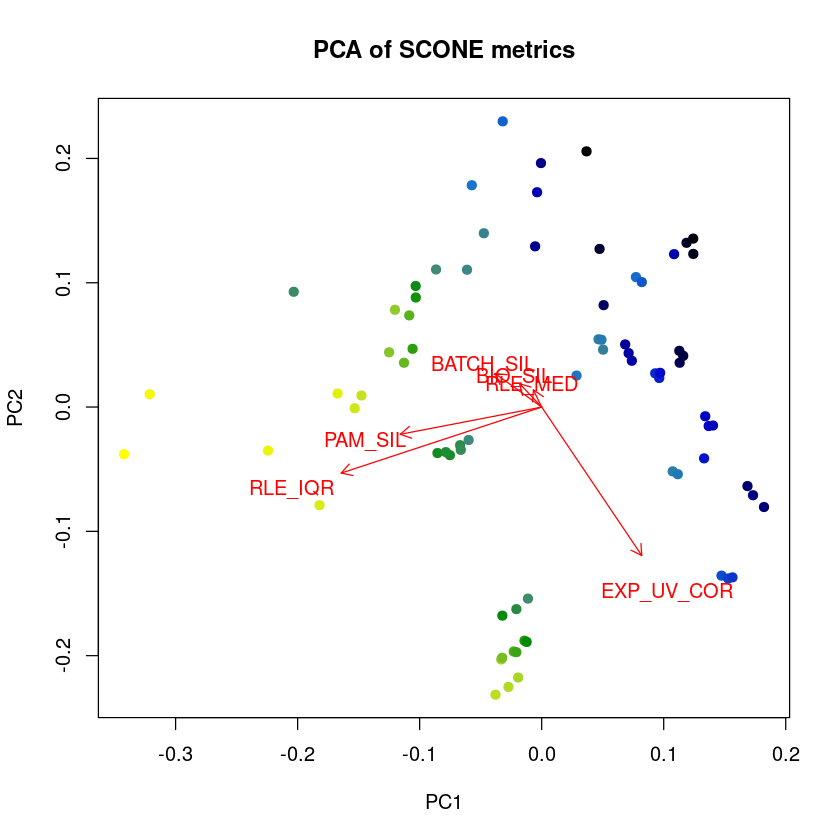

In [152]:
bp_obj = biplot_colored(pc_obj, y = -res$scores[,'mean_score'],expand = .6)
title('PCA of SCONE metrics')

## High score normalizations

In [226]:
head(res$scores)

,BIO_SIL,BATCH_SIL,PAM_SIL,EXP_QC_COR,EXP_UV_COR,EXP_WV_COR,RLE_MED,RLE_IQR,mean_score
"none,deseq,no_uv,no_bio,no_batch",-0.1376663,0.3991757,0.5022178,NA,-0.2892409,NA,-0.0008504976,-0.7942148,-0.05342985
"none,fq,no_uv,no_bio,no_batch",-0.1417659,0.4081318,0.5101578,NA,-0.3048712,NA,-0.0002226121,-0.8385879,-0.06119300
"none,uqp,no_uv,no_bio,no_batch",-0.1498649,0.3589001,0.4226251,NA,-0.2534073,NA,-0.0066374569,-0.8729780,-0.08356042
"none,deseq,ruv_k=1,no_bio,no_batch",-0.1397361,0.3583659,0.4723546,NA,-0.2450541,NA,-0.0033059181,-0.9839879,-0.09022727
"none,none,no_uv,no_bio,no_batch",-0.1586934,0.3363167,0.4312794,NA,-0.2145279,NA,-0.0256991472,-0.9111591,-0.09041391
"none,deseq,ruv_k=2,no_bio,no_batch",-0.1396720,0.3556571,0.4712522,NA,-0.2316802,NA,-0.0035107198,-0.9954188,-0.09056208


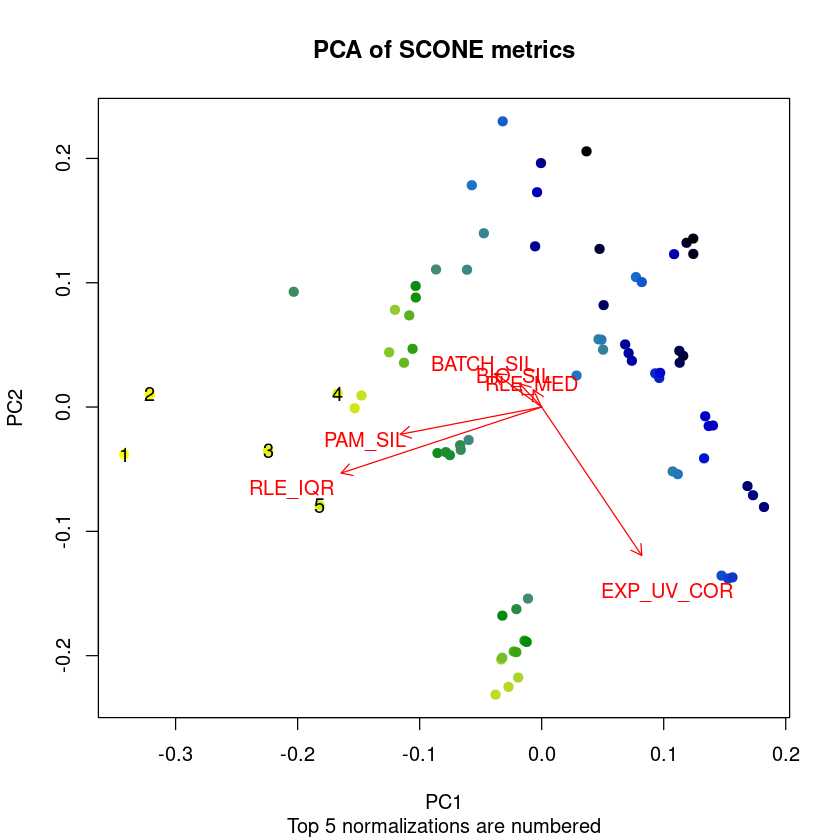

In [241]:
bp_obj = biplot_colored(pc_obj, y = -res$scores[,'mean_score'],expand = .6)

#points(t(bp_obj[grepl("none,deseq,no_uv,no_bio,no_batch",rownames(bp_obj)),]), pch = 1, col = "red", cex = 1.5)
#points(t(bp_obj[grepl("none,none,no_uv,no_bio,no_batch",rownames(bp_obj)),]), pch = 1, col = "blue", cex = 1.5)
#points(t(bp_obj[grepl("none,deseq,ruv_k=1,no_bio,no_batch",rownames(bp_obj)),]), pch = 1, col = "blue", cex = 1.5)

text(bp_obj[1:5,], labels=1:5)

title('PCA of SCONE metrics', sub='Top 5 normalizations are numbered')


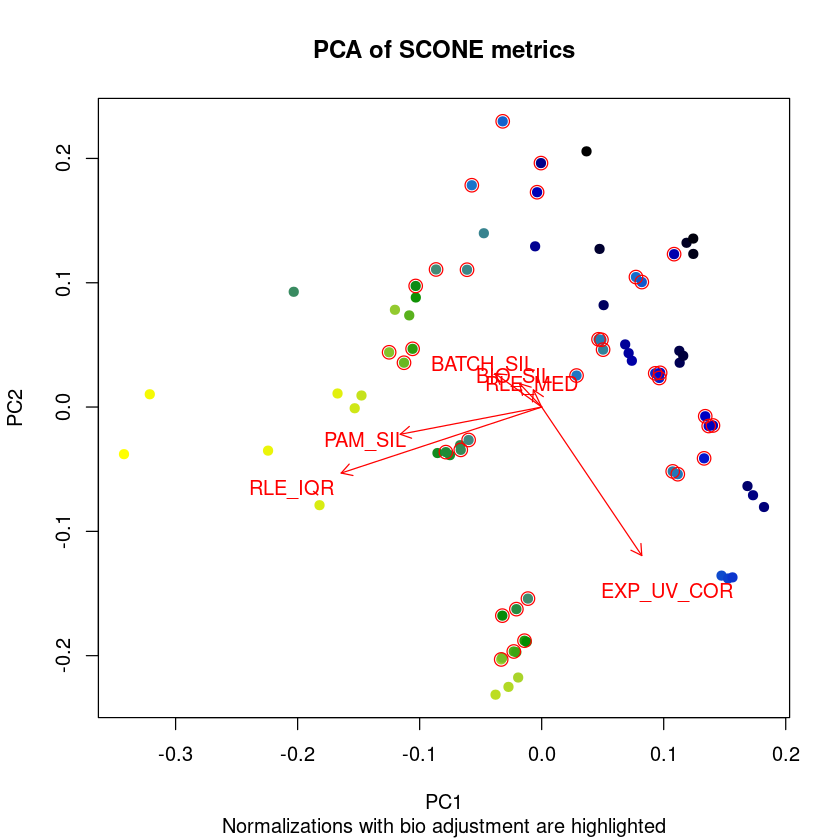

In [245]:
bp_obj = biplot_colored(pc_obj, y = -res$scores[,'mean_score'],expand = .6)

points(bp_obj[grepl(",bio",rownames(bp_obj)),], pch = 1, col = "red", cex = 1.5)

title('PCA of SCONE metrics', sub='Normalizations with bio adjustment are highlighted')


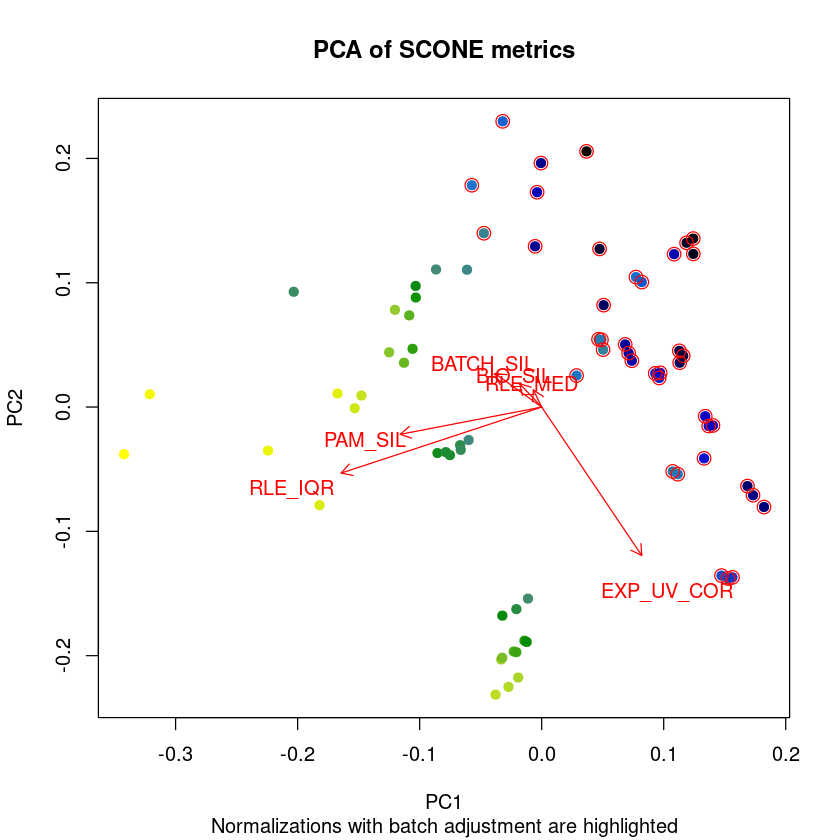

In [246]:
bp_obj = biplot_colored(pc_obj, y = -res$scores[,'mean_score'],expand = .6)

points(bp_obj[grepl(",batch",rownames(bp_obj)),], pch = 1, col = "red", cex = 1.5)

title('PCA of SCONE metrics', sub='Normalizations with batch adjustment are highlighted')


### SCONE's metrics

**BIO_SIL**. The average silhouette width of clusters defined by bio, defined with respect to a Euclidean distance metric over the first 3 expression PCs. Positive signature.

**BATCH_SIL**. The average silhouette width of clusters defined by batch, defined with respect to a Euclidean distance metric over the first 3 expression PCs. Negative signature.

**PAM_SIL**. The maximum average silhouette width of clusters defined by PAM clustering, defined with respect to a Euclidean distance metric over the first 3 expression PCs. Positive signature.

**EXP_QC_COR**. Maximum squared Spearman correlation between first 3 expression PCs and first k_qc QPCs. Negative signature.

**EXP_UV_COR**. Maximum squared Spearman correlation between first 3 expression PCs and first 3 PCs of the negative control (specified by eval_negcon or ruv_negcon by default) sub-matrix of the original (raw) data. Negative signature.

**EXP_WV_COR**. Maximum squared Spearman correlation between first 3 expression PCs and first 3 PCs of the positive control (specified by eval_poscon) sub-matrix of the original (raw) data. Positive signature.

**RLE_MED**. The mean squared median Relative Log Expression (RLE). Negative signature.

**RLE_IQR**. The mean inter-quartile range (IQR) of the RLE. Negative signature.


## Discussion

It seems like simple normalization strategies like DESeq, and quantile normalization perform better in this dataset.

One possibility is that DESeq's assumption that most genes are not DE across samples is valid. This "internal normalization" migh be better for this dataset than ERCC spike-ins. A median of 27 (out of 93) ERCC spike-ins are detected per cell. Non-DE genes provide a bigger set of genes for normalization.

Adjustment for biological and batch factors did not perform well. These asjustments were also based on ERCC. Using another set of housekeeping genes might improve the performance.

It is important to compare many normalization strategies.

In [225]:
sessionInfo()

R version 3.3.1 (2016-06-21)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Arch Linux

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] scone_0.0.7   ggplot2_2.1.0

loaded via a namespace (and not attached):
 [1] segmented_0.5-1.4          bitops_1.0-6              
 [3] matrixStats_0.50.2         RColorBrewer_1.1-2        
 [5] prabclus_2.2-6             GenomeInfoDb_1.8.7        
 [7] repr_0.9                   tools_3.3.1               
 [9] R6_2.1.3                   KernSmooth_2.23-15        
[11] DBI_0.5-1                  BiocGenerics_0.